In [1]:
#python libraries
import os
import re
from datetime import datetime
import pytz
import copy

#other ML libraries
import numpy as np
import pandas as pd #need pandas version < 2.0.0
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

/home/henrikhestnes/anaconda3/envs/LSTM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting random seeds for reproducibility
random_seed = 420
np.random.seed(random_seed)
_ = torch.manual_seed(random_seed)

### IMPORT PBM SIMULATION

In [3]:
result_file = open("./../PBM/sim_july.csv")

#Skipping first two lines
result_file.readline()
result_file.readline()

period = result_file.readline().split()[2:10]

zone_names = result_file.readline().split()
temp_map = {key:[] for key in zone_names}
start_day, start_month, year = period[3].split('/')
start_day, start_month, year = int(start_day), int(start_month), int(year) + 2000
counter = 1
while measured_temp := result_file.readline().split():
    for i, value in enumerate(measured_temp):
        if(i == 0):
            time = value
            hour, min = time.split('h')
            hour, min = int(hour), int(min)
            day = start_day + counter//24
            if day > 31: #TODO: Brute force, FIX
                day = 1
            month = start_month + counter//(24*31)
            datetime_obj = datetime(year=year, month=month, day=day, hour=hour, minute=min, tzinfo=pytz.timezone('Etc/GMT-2'))
            temp_map[zone_names[i]].append(datetime_obj)
        else:
            temp = value
            temp_map[zone_names[i]].append(float(temp))
    counter += 1

In [4]:
sim_temp = pd.DataFrame(temp_map)
sim_temp["Time"] = pd.to_datetime(sim_temp['Time'],  utc=True).dt.tz_convert('Etc/GMT-2')
sim_temp = sim_temp.set_index('Time')

rename_map = {"Time": "timestamp",
              "Ambientdb(C)(C)": "1OutdoorEntrance_temperature",
              "gfSleepdbT(C)": "0BRoom_temperature",
              "gfLivRoomdbT(C)": "0BTLivingRoom_temperature",
              "1fEntrancedbT(C)": "1Entrance_temperature",
              "1fSleep1dbT(C)": "1GuestRoom_temperature",
              "1fSleep2dbT(C)": "1MainRoom_temperature",
              "2fLivRoomdbT(C)": "2LivingRoomCenter_temperature",
              "2fOfficedbT(C)": "2OfficeDesk_temperature"}

sim_temp = sim_temp.reset_index()[rename_map.keys()].rename(columns=rename_map).set_index("timestamp").sort_index(axis=1)
sim_temp['2Fireplace_temperature'] = sim_temp['2LivingRoomCenter_temperature']
sim_temp['2Cooking_temperature'] = sim_temp['2LivingRoomCenter_temperature']
sim_temp.head(2)

,0BRoom_temperature,0BTLivingRoom_temperature,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1OutdoorEntrance_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature,2Fireplace_temperature,2Cooking_temperature
timestamp,,,,,,,,,,
2022-07-01 01:00:00+02:00,23.62,24.99,25.88,24.46,25.44,20.85,29.65,30.38,29.65,29.65
2022-07-01 02:00:00+02:00,23.41,24.81,25.78,24.29,25.79,20.45,28.90,29.73,28.90,28.90


### DATA CLEANING

In [5]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#, format="ISO8601")#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### FEATURE ENGINEERING ###

In [6]:
#Add hand-designed time-of-day and day-of-year features
positional_encoding = pd.DataFrame(index=sensor_data.index)

min_in_hour = 60
min_in_day = 24*min_in_hour
positional_encoding['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
positional_encoding['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
positional_encoding['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
positional_encoding['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
positional_encoding['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
positional_encoding['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

### DATA PREPROCESSING

In [7]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [8]:
train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
train_df = pd.concat([train_df_1, train_df_2])
val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()

train_labels = train_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(train_df)
y_scaler.fit(train_labels)

train_df_1_scaled = x_scaler.transform(train_df_1)
train_df_2_scaled = x_scaler.transform(train_df_2)
train_df_1_scaled = pd.DataFrame(train_df_1_scaled, columns=train_df.columns).set_index(train_df_1.index)
train_df_2_scaled = pd.DataFrame(train_df_2_scaled, columns=train_df.columns).set_index(train_df_2.index)
val_df_scaled = x_scaler.transform(val_df)
val_df_scaled = pd.DataFrame(val_df_scaled, columns=val_df.columns).set_index(val_df.index)
test_df_scaled = x_scaler.transform(test_df)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns).set_index(test_df.index)


print(f"Shape of train_df = {train_df.shape}, Shape of val_df = {val_df.shape}, Shape of test_df = {test_df.shape}")
print(f"Shape of labels = {train_labels.shape}")

Shape of train_df = (33214, 16), Shape of val_df = (2976, 16), Shape of test_df = (2976, 16)
Shape of labels = (33214, 10)


In [9]:
train_df.head(1)

,0BGuest_door,0BRoom_temperature,0BTLivingRoom_temperature,0B_door,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1Main_door,1OutdoorEntrance_temperature,2Cooking_temperature,2FirePlace_door,2Fireplace_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature
timestamp,,,,,,,,,,,,,,,,
2022-01-07 19:45:00+00:00,1.0,16.2,19.0875,1.0,19.65,16.25,14.9,1.0,-2.75,20.9,1.0,23.6,21.4,19.775,1.0,21.15


In [10]:
import WindowGenerator
import importlib
importlib.reload(WindowGenerator)

measurements_per_day = 4*24
sequence_width = measurements_per_day #24 hours
label_width = 8 #2 hours
shift = 0

label_columns = train_labels.columns

train_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift)
train_windows.add_data(train_df_1_scaled, positional_encoding, label_columns)
train_windows.add_data(train_df_2_scaled, positional_encoding, label_columns)
val_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift)
val_windows.add_data(val_df_scaled, positional_encoding, label_columns)
test_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift)
test_windows.add_data(test_df_scaled, positional_encoding, label_columns)

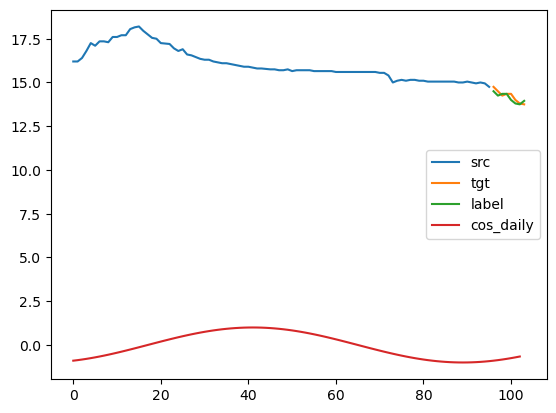

In [11]:
n = 0
src = x_scaler.inverse_transform(train_windows[n][0])[:,1]
tgt = y_scaler.inverse_transform(train_windows[n][1])[:,0]
cos_daily = train_windows[n][2][:, 0]
label = y_scaler.inverse_transform(train_windows[n][3])[:,0]
plt.plot(range(len(src)), src, label="src")
plt.plot(range(len(src), len(src)+len(label)), tgt, label="tgt")
plt.plot(range(len(src), len(src)+len(label)), label, label="label")
plt.plot(range(len(cos_daily)), cos_daily, label="cos_daily")
plt.legend()

In [12]:
batch_size = 200
train_loader = DataLoader(train_windows, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_windows, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_windows, batch_size=1, shuffle=False)

src, tgt, pos, label = next(iter(train_loader))
print("Features shape:", src.shape)
print("Target shape:", tgt.shape)
print("Positional shape:", pos.shape)
print("Label shape:", label.shape)

Features shape: torch.Size([200, 96, 16])
Target shape: torch.Size([200, 8, 10])
Positional shape: torch.Size([200, 103, 6])
Label shape: torch.Size([200, 8, 10])


### DOOR MODEL

In [63]:
import FFNNModel
import importlib
importlib.reload(FFNNModel)

layers = [17, 128, 64, 5]
door_model = FFNNModel.Net(layers)
door_model.load_state_dict(torch.load('./models/door_model'))
print(door_model)


Net(
  (linear_layers): ModuleList(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
  (act): ReLU()
  (sigmoid): Sigmoid()
)


### TRANSFORMER

In [46]:
import TransformerModel
import importlib
importlib.reload(TransformerModel)

d_model = 64
model = TransformerModel.Transformer(num_features=train_df.shape[1], num_labels=train_labels.shape[1], d_model=d_model,
                                     input_seq_length=sequence_width, output_seq_length=label_width)
# print(model)
do_train = False
if do_train:
    epochs = 1000 #early stopping, do not matter
    lr = 0.001
    l1_reg = 0
    model.train_model(train_loader, val_loader, epochs, lr, l1_reg)

In [14]:
save = False
if save:
    torch.save(model.state_dict(), f'./models/transformer_overfit')

In [47]:
overfit_model = TransformerModel.Transformer(num_features=train_df.shape[1], num_labels=train_labels.shape[1], d_model=64, input_seq_length=sequence_width, output_seq_length=label_width)
overfit_model.load_state_dict(torch.load('./models/transformer_overfit'))

<All keys matched successfully>

In [48]:
best_model = TransformerModel.Transformer(num_features=train_df.shape[1], num_labels=train_labels.shape[1], d_model=64, input_seq_length=sequence_width, output_seq_length=label_width)
best_model.load_state_dict(torch.load('./models/transformer_best'))

<All keys matched successfully>

In [49]:
model_5 = TransformerModel.Transformer(num_features=train_df.shape[1], num_labels=train_labels.shape[1], d_model=64, input_seq_length=sequence_width, output_seq_length=label_width)
model_5.load_state_dict(torch.load('./models/model_5'))

<All keys matched successfully>

### EXAMINE MODEL

In [ ]:
predictions = []
ground_truth = []
for src, tgt, pos, label in test_loader:
    zero_tgt = torch.zeros_like(tgt)
    pred = best_model(src, tgt, pos)
    predictions.append(y_scaler.inverse_transform(pred.detach().numpy().reshape(-1, 10)))
    ground_truth.append(y_scaler.inverse_transform(label.reshape(-1, 10)))


predictions = np.array(predictions[:-1])
ground_truth = np.array(ground_truth[:-1])

print('Error on validation data')

mse_val = np.mean(np.power((predictions - ground_truth), 2))
print(f'MSE:  {mse_val.item()}')

mae_val = np.mean(np.abs(predictions - ground_truth))
print(f'MAE:  {mae_val.item()}')

mape_val = 100*np.mean(np.abs(np.divide(predictions - ground_truth, ground_truth)))
print(f'MAPE: {mape_val.item()} %')

# FORECAST

In [66]:
model_5(test_windows[0][0].unsqueeze(0), test_windows[0][1].unsqueeze(0), test_windows[0][2].unsqueeze(0)).shape

torch.Size([1, 8, 10])

In [60]:
test_windows[0][2].shape

torch.Size([103, 6])

In [82]:
def rolling_forecast(model, door_model, start_window, future_windows, steps, timesteps_per_step):
    temp_mask = [(column in train_labels) for column in data.columns]
    temp_indices = [i for i, x in enumerate(temp_mask) if x == True]

    cols_to_update = ['1OutdoorEntrance_temperature']
    cols_to_update_mask = [(column in cols_to_update) for column in data.columns]
    cols_to_update_indices = [i for i, x in enumerate(cols_to_update_mask) if x == True]

    door_mask = train_df.columns.str.endswith('door')
    door_indices = [i for i, name in enumerate(train_df.columns) if door_mask[i]]
    not_door_indices = [i for i, name in enumerate(train_df.columns) if not door_mask[i]]

    current_window = start_window[0].clone()
    current_pos_enc = start_window[2].clone()

    predictions = []
    ground_truth = []
    for i in range(steps):
        next_pred = model.run_inference(current_window.unsqueeze(0), current_pos_enc.unsqueeze(0), timesteps_per_step)
        next_state = current_window[-timesteps_per_step:].clone()
        
        for label_index, window_index in enumerate(temp_indices):
            for n, row in enumerate(next_pred[0]):
                next_state[n][window_index] = row[label_index]
        
        for window_index in cols_to_update_indices:
            for n in range(timesteps_per_step):
                if window_index == cols_to_update_indices[0]:
                    bias = float(np.random.randint(75, 125))/100
                    next_state[n][window_index] = bias*future_windows[timesteps_per_step*i][0][-(timesteps_per_step-n)][window_index]
                else:
                    next_state[n][window_index] = future_windows[timesteps_per_step*i][0][-(timesteps_per_step-n)][window_index]
        
        doors_removed = next_state[:, not_door_indices]
        print(next_state.shape)
        print(doors_removed.shape)
        print(future_windows[timesteps_per_step*i][2].shape)
        door_pred = door_model(torch.cat((doors_removed, future_windows[timesteps_per_step*i][2][-8:]), dim=1)).round()
        for door_index, window_index in enumerate(door_indices):
            for n in range(timesteps_per_step):
                next_state[n][window_index] = door_pred[door_index]
        current_window = torch.roll(current_window, -timesteps_per_step, dims=0)
        current_window[-timesteps_per_step:] = next_state

        predictions.append(next_pred[0].detach().numpy())
        ground_truth.append(future_windows[timesteps_per_step*i][0][-timesteps_per_step:, temp_indices].detach().numpy())
    
    for i in range(len(ground_truth)):
        ground_truth[i] = y_scaler.inverse_transform(ground_truth[i])
        predictions[i] = y_scaler.inverse_transform(predictions[i])

    input_seq = x_scaler.inverse_transform(start_window.detach().numpy())
    temp_input_seq = []
    for input in input_seq:
        temp_input_seq.append(np.array(input[temp_indices]))
    
    predictions = np.array(predictions).reshape(-1, 10).T
    ground_truth = np.array(ground_truth).reshape(-1, 10).T
    temp_input_seq = np.array(temp_input_seq).reshape(-1, 10).T
    
    return predictions, ground_truth, temp_input_seq

### 2 HOUR FORECAST

In [50]:
predictions = []
ground_truth = []
source = []
target = []

label_mask = [(column in train_labels) for column in data.columns]
label_indices = [i for i, x in enumerate(label_mask) if x == True]

model.eval()
with torch.no_grad():
    for i, (src, tgt, pos, label) in enumerate(test_loader):
        pred = model_5.run_inference(src[0].unsqueeze(0), pos[0].unsqueeze(0), label.shape[1])
        predictions.append(y_scaler.inverse_transform(pred.detach().numpy()[0]))
        ground_truth.append(y_scaler.inverse_transform(label[0]))
        target.append(y_scaler.inverse_transform(tgt[0]))
        source.append(y_scaler.inverse_transform(src[0, :, label_indices].detach().numpy()))


predictions = np.array(predictions[:-1])
ground_truth = np.array(ground_truth[:-1])
source = np.array(source[:-1])
target = np.array(target[:-1])

print('Error on validation data')

mse_val = np.mean(np.power((predictions - ground_truth), 2))
print(f'MSE:  {mse_val.item()}')

mae_val = np.mean(np.abs(predictions - ground_truth))
print(f'MAE:  {mae_val.item()}')

mape_val = 100*np.mean(np.abs(np.divide(predictions - ground_truth, ground_truth)))
print(f'MAPE: {mape_val.item()} %')

Error on validation data
MSE:  1.065427670485923
MAE:  0.7548610588760702
MAPE: 3.381547906479074 %


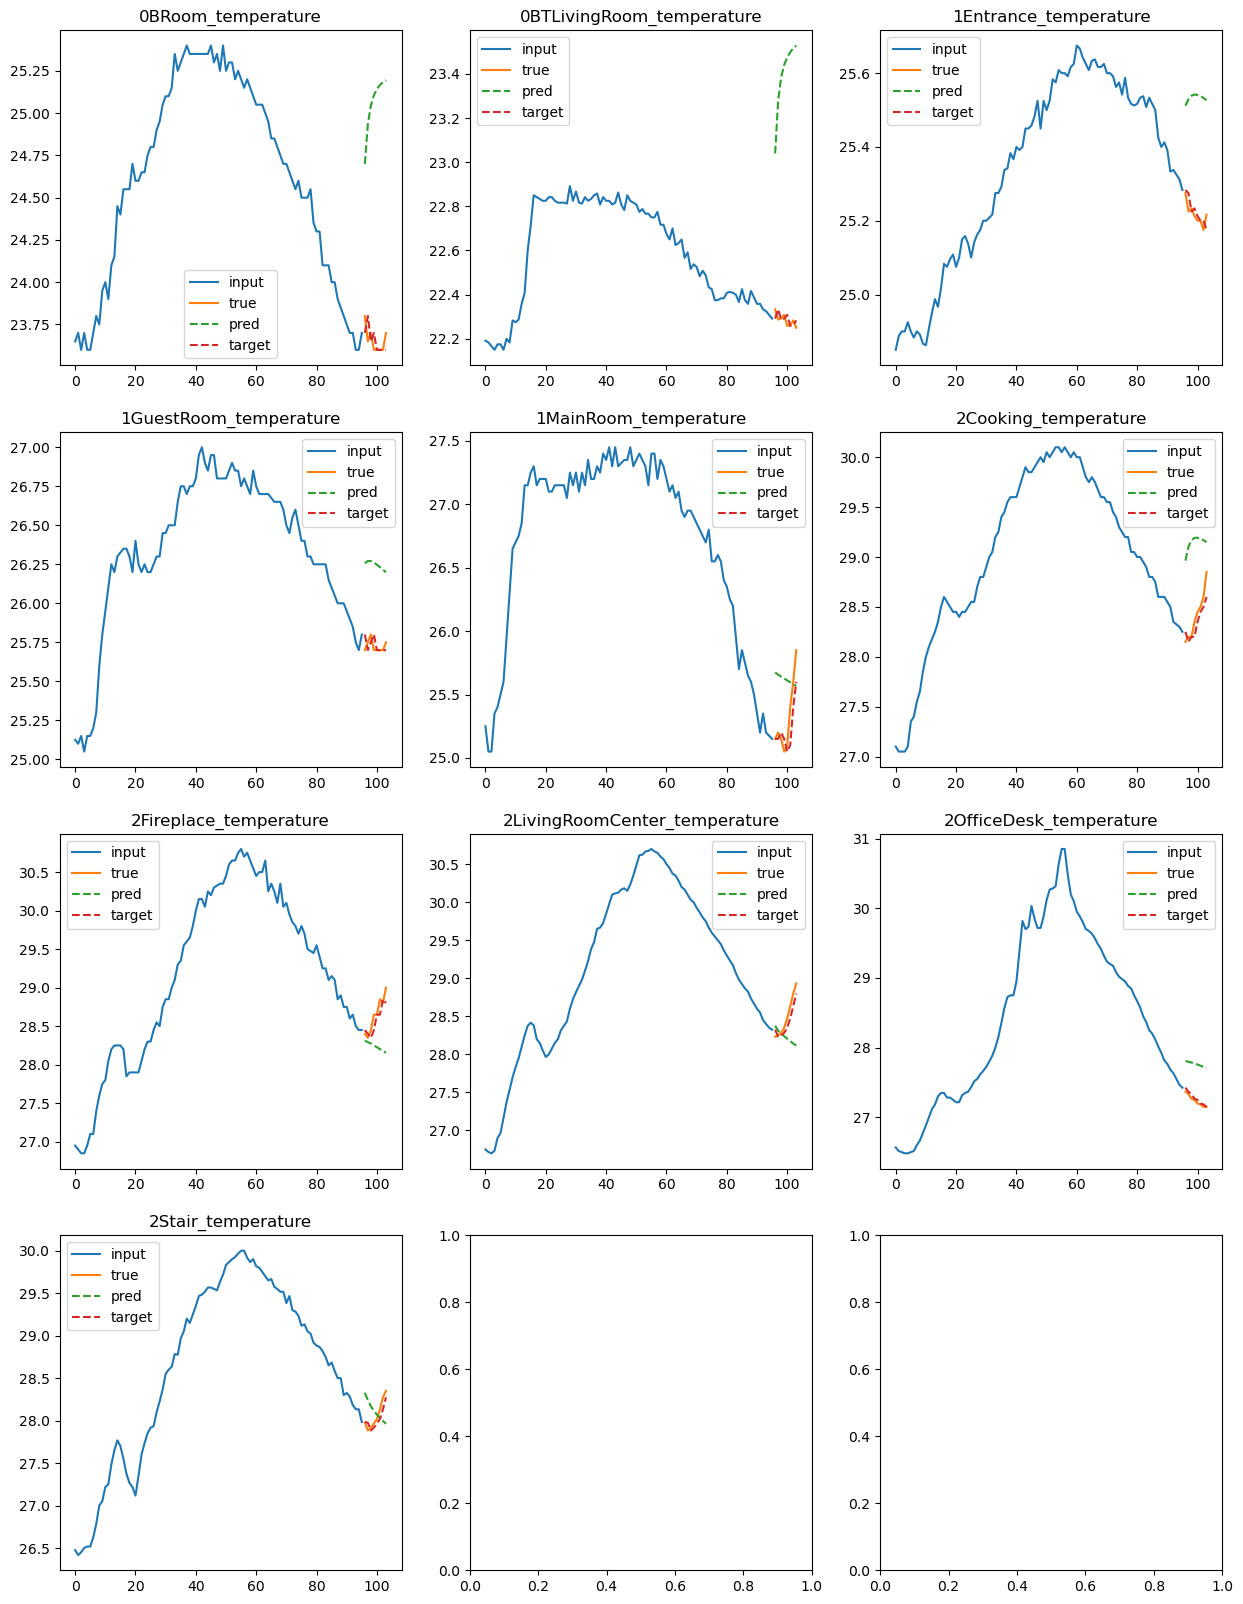

In [ ]:
plot_i = 10
fig,ax = plt.subplots(4,3,figsize=(15,20))
for i in range(predictions.shape[2]):
    input_indices = range(source.shape[1])
    pred_indices = range(source.shape[1], source.shape[1] + 8)
    ax[i//3, i%3].plot(input_indices, source[plot_i, :, i], label="input")
    ax[i//3, i%3].plot(pred_indices, ground_truth[plot_i, :, i], label="true")
    ax[i//3, i%3].plot(pred_indices, predictions[plot_i, :, i], '--', label="pred")
    ax[i//3, i%3].plot(pred_indices, target[plot_i, :, i], '--', label="target")
    ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
    ax[i//3, i%3].legend()

In [89]:
def rolling_forecast(model, door_model, start_window, future_windows, steps, timesteps_per_step):
    temp_mask = [(column in train_labels) for column in data.columns]
    temp_indices = [i for i, x in enumerate(temp_mask) if x == True]

    cols_to_update = ['1OutdoorEntrance_temperature']
    cols_to_update_mask = [(column in cols_to_update) for column in data.columns]
    cols_to_update_indices = [i for i, x in enumerate(cols_to_update_mask) if x == True]

    door_mask = train_df.columns.str.endswith('door')
    door_indices = [i for i, name in enumerate(train_df.columns) if door_mask[i]]
    not_door_indices = [i for i, name in enumerate(train_df.columns) if not door_mask[i]]

    current_window = start_window[0].clone()
    current_pos_enc = start_window[2].clone()

    predictions = []
    ground_truth = []
    for i in range(steps):
        next_pred = model.run_inference(current_window.unsqueeze(0), current_pos_enc.unsqueeze(0), timesteps_per_step)
        next_state = current_window[-timesteps_per_step:].clone()
        
        for label_index, window_index in enumerate(temp_indices):
            for n, row in enumerate(next_pred[0]):
                next_state[n][window_index] = row[label_index]
        
        for window_index in cols_to_update_indices:
            for n in range(timesteps_per_step):
                if window_index == cols_to_update_indices[0]:
                    bias = float(np.random.randint(75, 125))/100
                    next_state[n][window_index] = bias*future_windows[timesteps_per_step*i][0][-(timesteps_per_step-n)][window_index]
                else:
                    next_state[n][window_index] = future_windows[timesteps_per_step*i][0][-(timesteps_per_step-n)][window_index]
        
        doors_removed = next_state[:, not_door_indices]
        door_pred = door_model(torch.cat((doors_removed, future_windows[timesteps_per_step*i][2][-8:]), dim=1)).round()
        for door_index, window_index in enumerate(door_indices):
            for n in range(timesteps_per_step):
                next_state[n][window_index] = door_pred[n][door_index]
        current_window = torch.roll(current_window, -timesteps_per_step, dims=0)
        current_window[-timesteps_per_step:] = next_state

        predictions.append(next_pred[0].detach().numpy())
        ground_truth.append(future_windows[timesteps_per_step*i][0][-timesteps_per_step:, temp_indices].detach().numpy())
    
    for i in range(len(ground_truth)):
        ground_truth[i] = y_scaler.inverse_transform(ground_truth[i])
        predictions[i] = y_scaler.inverse_transform(predictions[i])

    input_seq = x_scaler.inverse_transform(start_window[0].detach().numpy())
    temp_input_seq = []
    for input in input_seq:
        temp_input_seq.append(np.array(input[temp_indices]))
    
    predictions = np.array(predictions).reshape(-1, 10).T
    ground_truth = np.array(ground_truth).reshape(-1, 10).T
    temp_input_seq = np.array(temp_input_seq).reshape(-1, 10).T
    
    return predictions, ground_truth, temp_input_seq

### 1 DAY FORECAST

In [90]:
steps_per_pred = 8
steps_per_day = 12
pred_steps = steps_per_day
num_pred = 50

used_windows = test_windows

np.random.seed(random_seed)
eval_windows_index = np.random.choice(range(0, len(used_windows)-pred_steps*steps_per_pred-1), num_pred)

predictions_1_day = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
ground_truths_1_day = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
temp_input_seqs_1_day = np.zeros((num_pred, used_windows[0][1].shape[1], used_windows[0][0].shape[0]))

for i, start_index in enumerate(eval_windows_index):
    start_window = used_windows[start_index]
    future_window = used_windows[start_index+1:start_index+steps_per_pred*pred_steps+1]
    prediction, ground_truth, temp_input_seq = rolling_forecast(model_5, door_model, start_window, future_window, pred_steps, steps_per_pred)
    predictions_1_day[i] = prediction
    ground_truths_1_day[i] = ground_truth
    temp_input_seqs_1_day[i] = temp_input_seq
    print(f"Start index: {start_index}, Forecast MAE:  {np.mean(np.abs(ground_truth - prediction))}")

print(f'Avg forecast MAE: {np.mean(np.abs(ground_truths_1_day-predictions_1_day))}')
pbm_indices = [0, 1, 2, 3, 4, 5, 8]
print(f'Avg forecast MAE for sensors used in PBM: {np.mean(np.abs(ground_truths_1_day[:, pbm_indices] - predictions_1_day[:, pbm_indices]))}')

Start index: 1096, Forecast MAE:  3.2173852920532227
Start index: 390, Forecast MAE:  1.773019790649414
Start index: 575, Forecast MAE:  1.3233623504638672
Start index: 799, Forecast MAE:  1.3395540714263916
Start index: 2675, Forecast MAE:  1.8044192790985107
Start index: 1966, Forecast MAE:  2.447274684906006
Start index: 1209, Forecast MAE:  2.038344383239746
Start index: 2202, Forecast MAE:  2.1294312477111816
Start index: 266, Forecast MAE:  1.8187942504882812
Start index: 840, Forecast MAE:  1.5923542976379395
Start index: 2711, Forecast MAE:  1.085977554321289
Start index: 1678, Forecast MAE:  1.2892433404922485
Start index: 1254, Forecast MAE:  0.7306453585624695
Start index: 724, Forecast MAE:  1.8088921308517456
Start index: 803, Forecast MAE:  1.2351641654968262
Start index: 152, Forecast MAE:  2.627667188644409
Start index: 1668, Forecast MAE:  0.9797341823577881
Start index: 2496, Forecast MAE:  1.939653992652893
Start index: 717, Forecast MAE:  1.3810216188430786
Start in

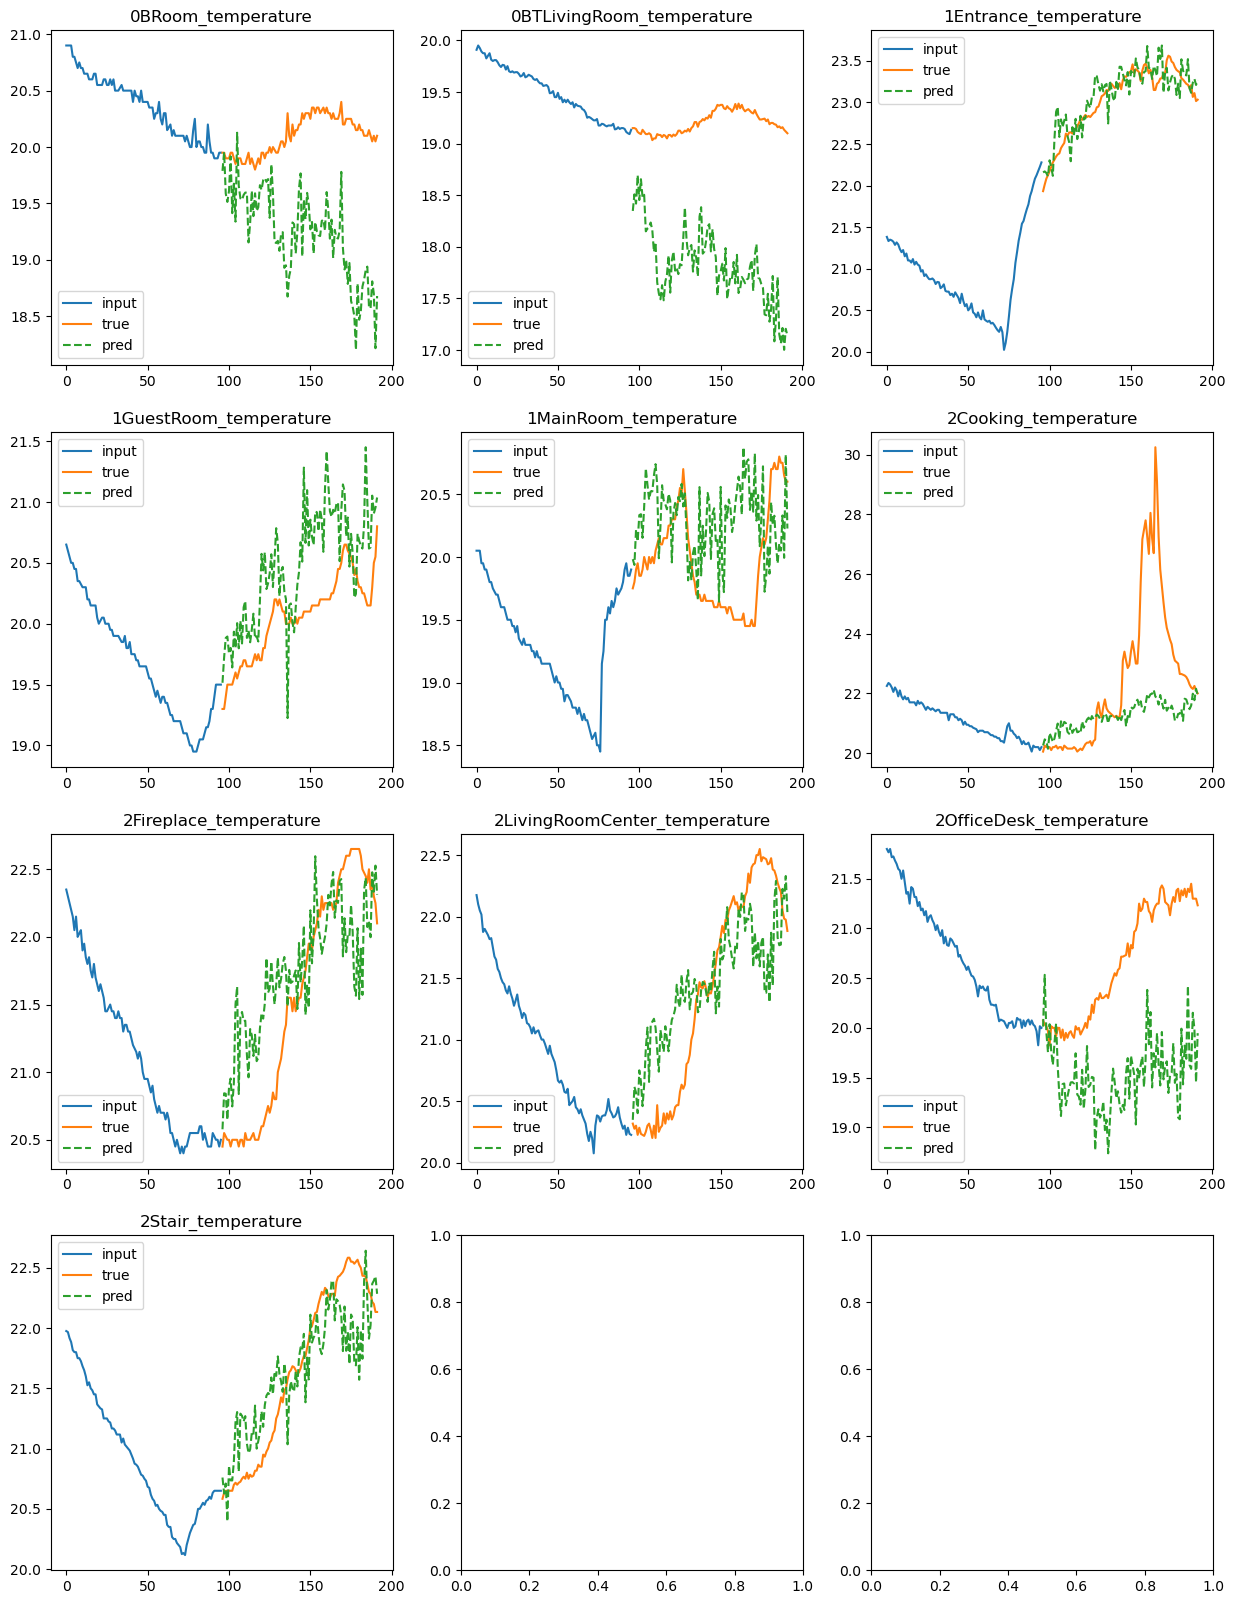

In [94]:
plot_i = 12
fig,ax = plt.subplots(4,3,figsize=(15,20))
for i in range(predictions_1_day.shape[1]):
    input_indices = range(len(start_window[0]))
    pred_indices = range(len(input_indices), len(input_indices) + 8*12)
    ax[i//3, i%3].plot(input_indices, temp_input_seqs_1_day[plot_i][i], label="input")
    ax[i//3, i%3].plot(pred_indices, ground_truths_1_day[plot_i][i], label="true")
    ax[i//3, i%3].plot(pred_indices, predictions_1_day[plot_i][i], '--', label="pred")
    ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
    ax[i//3, i%3].legend()

### SANDBOX

In [ ]:
predictions[plot_i, :, 0].shape

(8,)

In [ ]:
np.mean(np.abs(ground_truth[plot_i, :, 0]-predictions[plot_i, :, 0]))

1.4027077788465734

In [26]:
src, tgt, pos, label = next(iter(train_loader))
model_5.eval()
pred = best_model(src, tgt, pos)
torch.mean(torch.pow(label-pred, 2))


tensor(0.0464, grad_fn=<MeanBackward0>)

In [28]:
np.mean(np.power(y_scaler.inverse_transform(pred.detach()[1]) - y_scaler.inverse_transform(label[1]), 2))

0.2906471843931768

In [30]:
mse = 0
for i in range(len(pred)):
    mse += np.mean(np.power(y_scaler.inverse_transform(pred.detach()[i]) - y_scaler.inverse_transform(label[i]), 2))
mse /= len(pred)
mse

0.36288036849893035

In [ ]:
src[0][:, label_indices][1]

tensor([-0.4760, -0.9551, -1.3258,  0.1488,  0.4724,  0.5286,  0.4207,  0.6868,
        -0.4166,  0.5228])

In [ ]:
label[0]

tensor([[-0.5632, -1.0238, -1.2834,  0.2616,  0.5724,  0.4439,  0.3180,  0.5135,
         -0.5220,  0.4460],
        [-0.5457, -1.0287, -1.2384,  0.2616,  0.5891,  0.4439,  0.3009,  0.5299,
         -0.4994,  0.4588],
        [-0.5457, -1.0303, -1.2993,  0.2777,  0.5724,  0.4608,  0.3180,  0.5528,
         -0.4969,  0.4652],
        [-0.5283, -1.0139, -1.2940,  0.3099,  0.5724,  0.4269,  0.3180,  0.5299,
         -0.5019,  0.4844],
        [-0.5109, -1.0238, -1.3020,  0.3179,  0.5724,  0.4269,  0.3266,  0.5920,
         -0.4969,  0.5036],
        [-0.5283, -1.0189, -1.3417,  0.3260,  0.5558,  0.4608,  0.3352,  0.5299,
         -0.4693,  0.5100],
        [-0.5109, -1.0369, -1.2993,  0.3421,  0.5558,  0.4947,  0.3523,  0.5854,
         -0.4969,  0.5228],
        [-0.5109, -1.0172, -1.3814,  0.3743,  0.5724,  0.5456,  0.3694,  0.5985,
         -0.4919,  0.5228]])

In [32]:
x_scaler.inverse_transform(src[n].detach())[:, label_indices].shape

(96, 10)

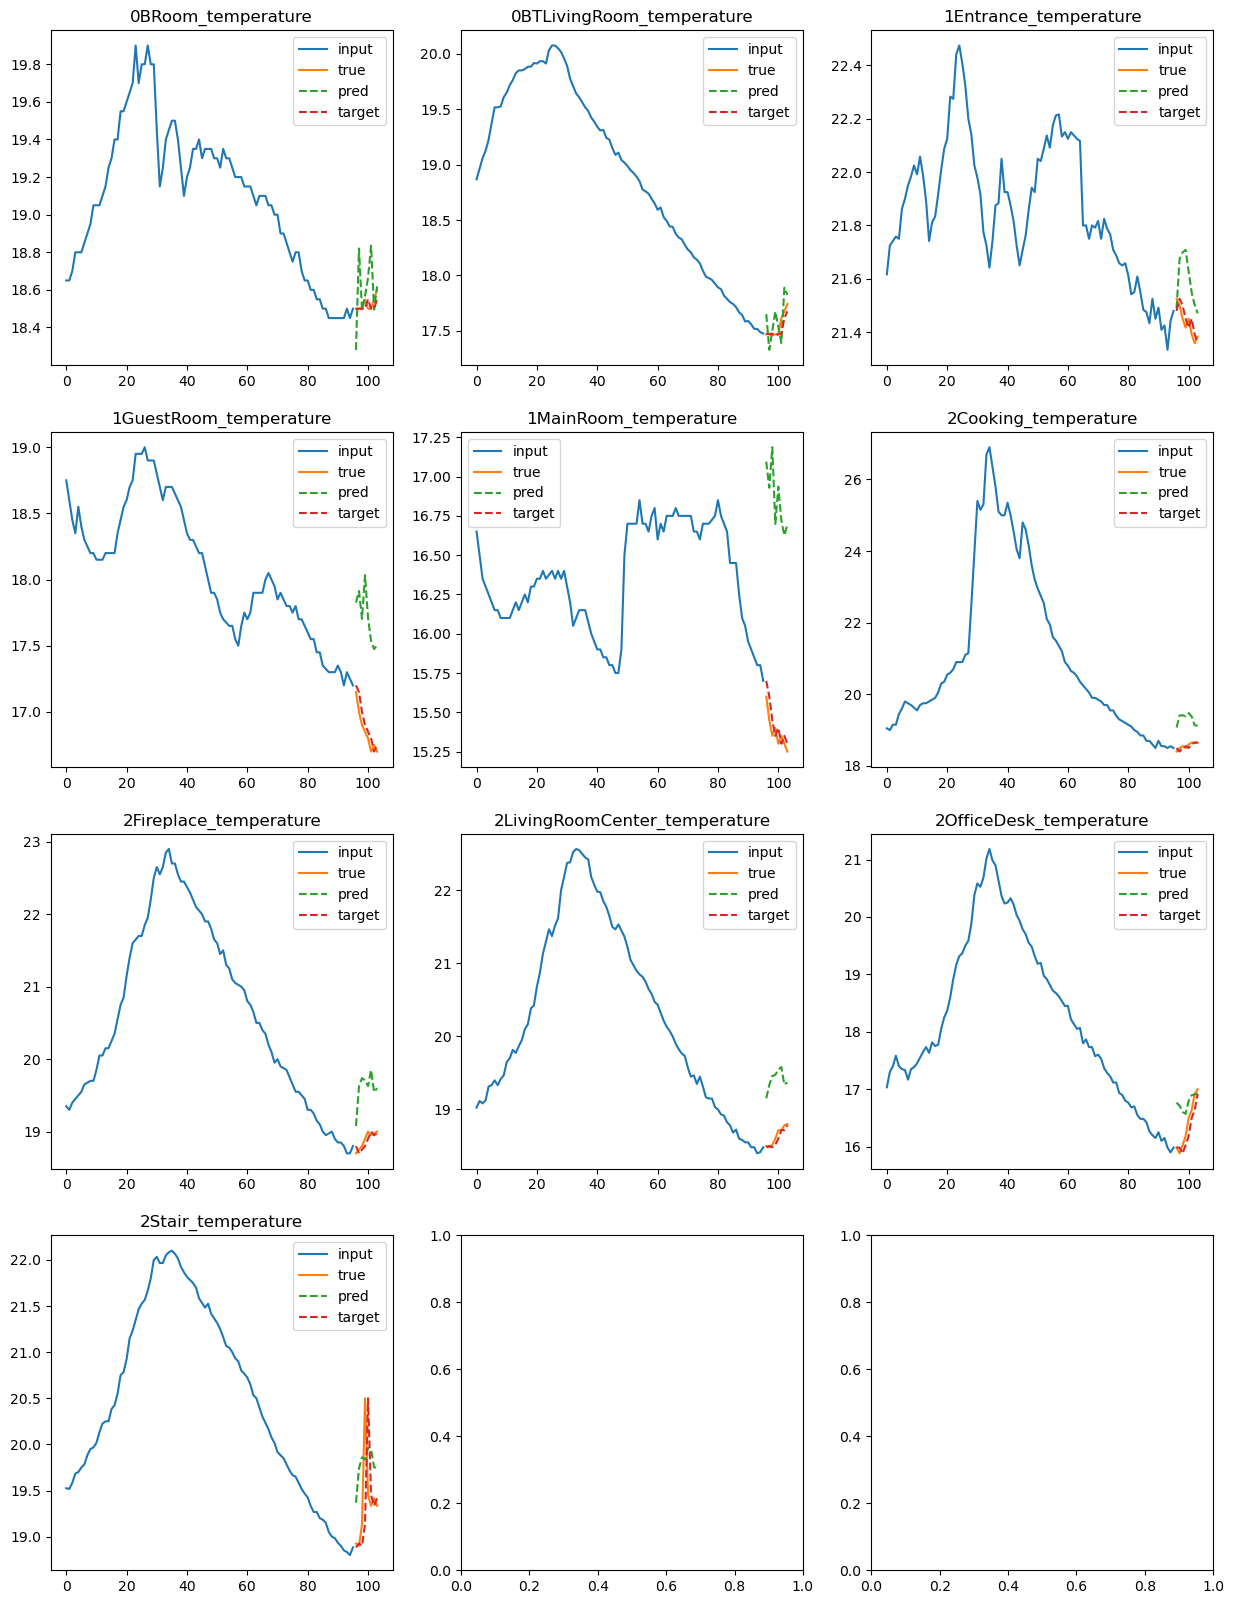

In [31]:
plot_i = 100
n = 100
fig,ax = plt.subplots(4,3,figsize=(15,20))
for i in range(10):
    input_indices = range(source.shape[1])
    pred_indices = range(source.shape[1], source.shape[1] + 8)
    ax[i//3, i%3].plot(input_indices, x_scaler.inverse_transform(src[n].detach())[:, label_indices][:, i], label="input")
    ax[i//3, i%3].plot(pred_indices, y_scaler.inverse_transform(label[n])[:, i], label="true")
    ax[i//3, i%3].plot(pred_indices, y_scaler.inverse_transform(pred.detach()[n])[:, i], '--', label="pred")
    ax[i//3, i%3].plot(pred_indices, y_scaler.inverse_transform(tgt[n])[:, i], '--', label="target")
    ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
    ax[i//3, i%3].legend()
